# Engenharia e seleção de features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib #Para salvar o modelo 
from sklearn.experimental import enable_halving_search_cv # Necessário para importar
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import HalvingRandomSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Input
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint # Para a distribuição de parâmetros
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
import pickle
import os, random
import utils
from functools import partial

2025-11-25 09:18:59.132907: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 09:18:59.163824: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 09:19:00.165036: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Observações:

1 - As bibliotecas que serão usadas neste projeto possuem fontes múltiplas de aleatoriedade. Por isso ressalta-se os seguintes pontos abaixo:

- numpy, random (do Python), e tensorflow usam geradores diferentes.

    - Fixar random_state em HalvingRandomSearchCV só controla o sorteio dos hiperparâmetros, não o comportamento interno da rede.

- TensorFlow e paralelismo introduzem aleatóriedade.

    - Por padrão, TensorFlow usa múltiplas threads e kernels otimizados (como cuDNN no GPU), que executam operações não determinísticas (principalmente Dropout e Dense).

- O KerasRegressor recria o modelo a cada chamada

    - Mesmo que o random_state do scikit-learn esteja fixo, cada vez que fit() é chamado, o Sequential() do TensorFlow usa um estado de aleatoriedade independente (a menos que se fixe isso manualmente dentro da função que cria o modelo).

Dadas as observações acima, fixa-se abaixo o parâmetro SEED para alguns métodos que serão utilizados neste notebook.



2 - Ao rodar o processo de criação do modelo, na minha máquina, com o parâmetro n_jobs diferente de 1, havia o seguinte warning:

   
    UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak. 
   

- Ao parar, todo o processo de seleção de parâmetros ótimos era comprometido e não havia reproducibilidade do modelo à cada rodada.

- Colocando o n_jobs = 1, garante-se a reproducibilidade do modelo, ao custo de aumentar bastante o tempo de treinamento do modelo

- Caso esse modelo seja rodado em uma máquina mais robusta, esse problema pode não ocorrer, sendo possível acelerar o tempo de treinamento ao mudar-se o valor do parâmetro n_jobs.

# Parâmetros

In [2]:
# Desativar GPU (garante total determinismo)
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Fixar sementes globais
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Garante execução determinística, desativando otimizações não reprodutíveis
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Numero de neuronios de entrada na rede neural
neuronios_entrada = 100

n_jobs = 1

caminho_features_selecionadas = '../data/08_reporting/selected_non_linear_features.npy'

caminho_dados = '../data/02_intermediate/training_b_df.csv'

caminho_modelo = '../data/06_models/modelo_notebook_3.joblib'

caminho_shap = '../data/08_reporting/shap_values_calculados.npy'

caminho_X_train_non_linear_features = '../data/03_primary/X_train_non_linear_features.npy'

caminho_y_train_non_linear_features = '../data/03_primary/y_train_non_linear_features.npy'

# 1 - Lendo os dados

In [3]:
df = pd.read_csv(caminho_dados)

In [4]:
X_train = df.drop(columns=['r'])
y_train = df['r']

In [5]:
X_train

,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,...,cl_502,cl_503,cl_504,cl_505,cl_506,cl_507,cl_508,cl_509,cl_510,cl_511
0,0.000172,0.000066,0.000078,0.000069,0.000063,0.000021,0.000053,0.000031,0.000043,0.000060,...,6.490171e-10,6.058483e-10,6.123373e-10,5.492230e-10,4.987756e-10,4.996063e-10,4.873860e-10,4.858634e-10,3.759005e-10,4.054609e-10
1,0.000058,0.000068,0.000118,0.000045,0.000045,0.000043,0.000063,0.000035,0.000042,0.000061,...,6.590990e-10,5.957533e-10,5.382490e-10,5.511306e-10,4.965663e-10,4.848698e-10,4.638441e-10,4.146040e-10,3.850935e-10,3.658829e-10
2,0.000066,0.000086,0.000129,0.000044,0.000056,0.000038,0.000041,0.000059,0.000060,0.000048,...,6.345819e-10,6.044535e-10,5.756162e-10,5.306156e-10,4.744517e-10,4.625054e-10,4.354919e-10,3.960931e-10,3.977156e-10,3.608611e-10
3,0.000140,0.000167,0.000060,0.000070,0.000064,0.000030,0.000018,0.000049,0.000025,0.000042,...,6.901658e-10,6.067260e-10,5.923192e-10,5.206132e-10,5.064276e-10,4.546328e-10,4.771503e-10,4.041781e-10,3.925857e-10,3.493796e-10
4,0.000025,0.000066,0.000041,0.000060,0.000052,0.000034,0.000046,0.000031,0.000035,0.000084,...,7.062580e-10,6.144698e-10,5.878574e-10,5.581525e-10,5.349131e-10,4.615936e-10,4.710612e-10,4.277015e-10,3.812178e-10,3.678812e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.000138,0.000049,0.000021,0.000019,0.000019,0.000039,0.000031,0.000039,0.000046,0.000054,...,6.431329e-10,5.715559e-10,5.597664e-10,5.280729e-10,5.106220e-10,4.678772e-10,4.277167e-10,4.167436e-10,3.841709e-10,3.595660e-10
7996,0.000049,0.000049,0.000023,0.000023,0.000052,0.000026,0.000055,0.000036,0.000066,0.000094,...,6.537801e-10,5.945880e-10,5.588835e-10,5.163429e-10,4.827139e-10,4.791565e-10,4.352070e-10,4.263153e-10,3.777479e-10,3.572270e-10
7997,0.000084,0.000028,0.000024,0.000038,0.000044,0.000050,0.000049,0.000026,0.000089,0.000078,...,6.520265e-10,6.202956e-10,5.871600e-10,5.503659e-10,5.109527e-10,4.832764e-10,4.629816e-10,4.468772e-10,4.371018e-10,3.820512e-10
7998,0.000007,0.000125,0.000024,0.000012,0.000050,0.000034,0.000055,0.000085,0.000079,0.000103,...,6.219886e-10,5.591386e-10,5.611786e-10,5.009329e-10,5.056176e-10,4.515758e-10,4.394383e-10,4.093147e-10,3.904380e-10,3.585950e-10


In [6]:
y_train

0       0.002872
1       0.002872
2       0.002872
3       0.002872
4       0.002872
          ...   
7995    0.011467
7996    0.011467
7997    0.011467
7998    0.011467
7999    0.011467
Name: r, Length: 8000, dtype: float64

# 2 - Engenharia de features

Ao conversar com a astrofísica Camila Novaes que forneceu os dados simulados estudados aqui, foi sugerida a criação da média ponderada abaixo:

In [7]:
X_train = utils.cria_feature_media_ponderada(X_train)

print("Primeiras 5 linhas com a nova feature:")
print(X_train[['cl_2', 'cl_3', 'cl_4', 'cl_511', 'media_ponderada_Cls']].head())

Primeiras 5 linhas com a nova feature:
       cl_2      cl_3      cl_4        cl_511  media_ponderada_Cls
0  0.000172  0.000066  0.000078  4.054609e-10             0.000100
1  0.000058  0.000068  0.000118  3.658829e-10             0.000100
2  0.000066  0.000086  0.000129  3.608611e-10             0.000098
3  0.000140  0.000167  0.000060  3.493796e-10             0.000100
4  0.000025  0.000066  0.000041  3.678812e-10             0.000099


In [8]:
X_train['media_ponderada_Cls'].isnull().sum()

np.int64(0)

In [9]:
X_train['media_ponderada_Cls'].tail()

7995    0.000096
7996    0.000095
7997    0.000096
7998    0.000096
7999    0.000096
Name: media_ponderada_Cls, dtype: float64

### Interpretação Cosmológica da Feature

A feature media_ponderada_Cls é um indicador robusto da amplitude média da potência no regime das primeiras oscilações acústicas.

    O intervalo de ℓ=2 a ℓ=511 (que vai de grandes escalas angulares até o final do primeiro pico acústico) resume a força e a altura da primeira grande oscilação de compressão/expansão no plasma primordial.

    Uma media_ponderada_Cls maior implica que o espectro de potência é, em média, mais alto neste regime, o que geralmente se traduz em um universo com maior variação de temperatura (mais estrutura inicial).

# 3 - Seleção de features

Para a seleção de features utiliza-se o seguinte fluxo:

1 - Utiliza-se o método estatístico de seleção de features, SelectKBest do scikit-learn para se verificar correlações entre as features e o target.

2 - Mantém-se apenas as 30 features mais importantes.

3 - Verifica-se o desempenho da rede neural no conjunto de teste utilizando-se apenas as features selecionadas e compara-se com o desempenho obtido utilizando-se todas as features.

In [10]:
# 1. Instanciar o seletor.
k_best = SelectKBest(score_func=f_regression, k=neuronios_entrada)

# 2. Ajustar o seletor aos dados de TREINO (X e y)
k_best.fit(X_train, y_train.to_numpy().ravel())

# 3. Obter os scores e os índices das colunas selecionadas
scores = k_best.scores_
selected_features_indices = k_best.get_support(indices=True)
selected_feature_names = X_train.columns[selected_features_indices]

print("Features Selecionadas:", selected_feature_names)

Features Selecionadas: Index(['cl_14', 'cl_16', 'cl_17', 'cl_18', 'cl_19', 'cl_20', 'cl_21', 'cl_22',
       'cl_23', 'cl_24', 'cl_25', 'cl_26', 'cl_27', 'cl_28', 'cl_29', 'cl_30',
       'cl_31', 'cl_32', 'cl_33', 'cl_34', 'cl_35', 'cl_36', 'cl_37', 'cl_38',
       'cl_39', 'cl_40', 'cl_41', 'cl_42', 'cl_43', 'cl_44', 'cl_45', 'cl_46',
       'cl_47', 'cl_48', 'cl_49', 'cl_50', 'cl_51', 'cl_52', 'cl_53', 'cl_54',
       'cl_55', 'cl_56', 'cl_57', 'cl_58', 'cl_59', 'cl_60', 'cl_61', 'cl_62',
       'cl_63', 'cl_64', 'cl_65', 'cl_66', 'cl_67', 'cl_68', 'cl_69', 'cl_70',
       'cl_71', 'cl_72', 'cl_73', 'cl_74', 'cl_75', 'cl_76', 'cl_77', 'cl_78',
       'cl_79', 'cl_80', 'cl_81', 'cl_82', 'cl_83', 'cl_84', 'cl_85', 'cl_86',
       'cl_87', 'cl_88', 'cl_89', 'cl_90', 'cl_91', 'cl_92', 'cl_93', 'cl_94',
       'cl_95', 'cl_96', 'cl_97', 'cl_98', 'cl_99', 'cl_100', 'cl_101',
       'cl_102', 'cl_103', 'cl_104', 'cl_105', 'cl_106', 'cl_107', 'cl_108',
       'cl_109', 'cl_110', 'cl_111', '

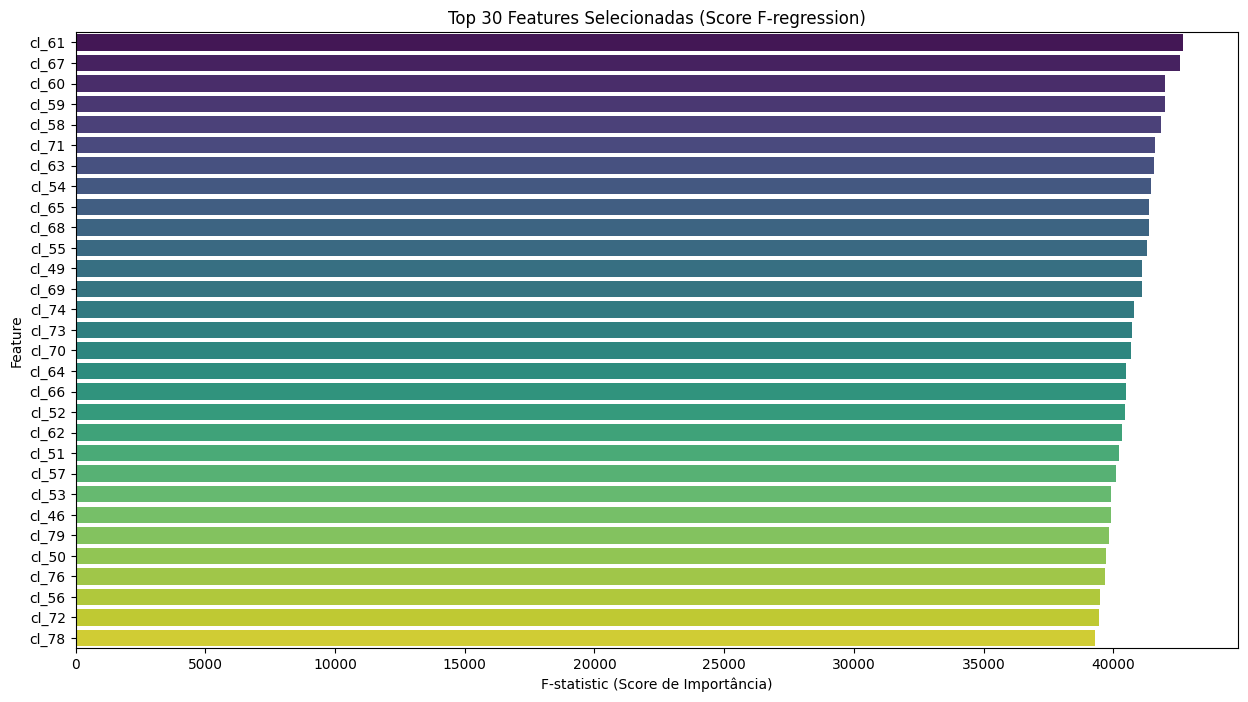

In [11]:
# O array 'scores' (F-statistic) tem o mesmo tamanho que X_train.columns
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance_Score': scores  # Este é o F-statistic
})

# Ordenar o DataFrame pelo Score de Importância em ordem decrescente
importance_df = importance_df.sort_values(by='Importance_Score', ascending=False).reset_index(drop=True)

K_FEATURES = 30
top_k_features_df = importance_df.head(K_FEATURES)

# Visualização (Gráfico de Barras) ---
plt.figure(figsize=(15, 8))
# Usamos o seaborn para um visual melhor
sns.barplot(x='Importance_Score', y='Feature', data=top_k_features_df, palette='viridis', hue= 'Feature', legend=False)

plt.title(f'Top {K_FEATURES} Features Selecionadas (Score F-regression)')
plt.xlabel('F-statistic (Score de Importância)')
plt.ylabel('Feature')
plt.show()

In [12]:
# Dataframe com a importancia de todas as features selecionadas para treinar o modelo
k_features_df = importance_df.head(neuronios_entrada)

In [13]:
# Força a visualização de todas as linhas
pd.set_option('display.max_rows', None)
k_features_df


,Feature,Importance_Score
0,cl_61,42674.791905
1,cl_67,42564.793028
2,cl_60,42003.823591
3,cl_59,41977.319437
4,cl_58,41837.569258
5,cl_71,41621.213792
6,cl_63,41579.567511
7,cl_54,41455.179335
8,cl_65,41376.030077
9,cl_68,41362.810610


## Observações

- As 100 features mais importantes não possuem valores de ℓ para os Cℓ​'s maior que 120. Isso corrobora com o conhecimento teórico de que a maior parte da informação cosmológica (como os picos acústicos) está concentrada nas baixas frequências (grandes escalas angulares), correspondentes aos ℓ's menores.

- O conhecimento teórico aponta para o valor Cℓ=10​ (ou Cℓ​ em torno de ℓ=10, o chamado plateau de baixa ℓ) como sendo de importância fundamental, pois carrega a informação sobre a reionização. Esse comportamento não é observado acima, onde outras Cℓ​'s dominaram o ranking. Esse resultado pode ser visto de duas maneiras:

    1. Os dados simulados apresentam alguma inconsistência ou viés estrutural.

    2. Outros Cℓ​'s, diferentes dos previstos, fornecem mais informações sobre o valor do alvo 'r' (Razão Tensor-Escalar) do que o esperado pela teoria.

- Ambos os resultados acima podem ser valiosos para os astrofísicos e cosmólogos que estejam trabalhando nesta área, pois indicam quais escalas angulares são mais sensíveis à variação do parâmetro 'r' dentro do conjunto de dados utilizado.

In [14]:
# Reseta a visualização para o máximo de 10 linhas
pd.set_option('display.max_rows', 10)

In [15]:
X_train = X_train[selected_feature_names]

In [16]:
X_train

,cl_14,cl_16,cl_17,cl_18,cl_19,cl_20,cl_21,cl_22,cl_23,cl_24,...,cl_105,cl_106,cl_107,cl_108,cl_109,cl_110,cl_111,cl_112,cl_113,cl_114
0,0.000061,0.000127,0.000098,0.000125,0.000164,0.000139,0.000263,0.000228,0.000213,0.000207,...,0.001986,0.001488,0.001495,0.001690,0.001581,0.001785,0.001795,0.001668,0.001474,0.001587
1,0.000066,0.000089,0.000179,0.000095,0.000101,0.000158,0.000195,0.000144,0.000183,0.000233,...,0.001601,0.001709,0.001512,0.001433,0.001550,0.001726,0.001482,0.001787,0.001473,0.001430
2,0.000097,0.000091,0.000074,0.000104,0.000097,0.000137,0.000122,0.000179,0.000204,0.000269,...,0.001371,0.001419,0.001519,0.001479,0.001566,0.001464,0.001449,0.001833,0.001716,0.001593
3,0.000072,0.000104,0.000083,0.000143,0.000121,0.000108,0.000240,0.000213,0.000305,0.000215,...,0.001599,0.001849,0.001695,0.001291,0.001544,0.001662,0.001522,0.001647,0.001576,0.001728
4,0.000062,0.000075,0.000139,0.000116,0.000128,0.000219,0.000093,0.000312,0.000234,0.000318,...,0.001564,0.001813,0.001611,0.001549,0.001564,0.001433,0.001586,0.001538,0.001734,0.001656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.000083,0.000140,0.000188,0.000145,0.000198,0.000207,0.000188,0.000225,0.000300,0.000217,...,0.001860,0.001488,0.001593,0.001454,0.001752,0.001407,0.001638,0.001732,0.001530,0.001494
7996,0.000096,0.000154,0.000164,0.000156,0.000278,0.000115,0.000235,0.000282,0.000331,0.000331,...,0.001490,0.001563,0.001518,0.001494,0.001850,0.001603,0.001575,0.001394,0.001487,0.001769
7997,0.000087,0.000119,0.000172,0.000180,0.000280,0.000213,0.000264,0.000203,0.000261,0.000255,...,0.001856,0.001622,0.001781,0.001765,0.001557,0.001588,0.001510,0.001562,0.001735,0.002060
7998,0.000113,0.000124,0.000265,0.000161,0.000153,0.000237,0.000323,0.000300,0.000342,0.000310,...,0.001839,0.001545,0.001554,0.001459,0.001539,0.001510,0.001527,0.001915,0.001654,0.001504


## Observação

Para plotar os gráficos SHAP com a explicabilidade dos modelos, salva-se abaixo as features usadas na modelagem.

In [17]:
selected_features = X_train.columns

In [18]:
selected_features

Index(['cl_14', 'cl_16', 'cl_17', 'cl_18', 'cl_19', 'cl_20', 'cl_21', 'cl_22',
       'cl_23', 'cl_24', 'cl_25', 'cl_26', 'cl_27', 'cl_28', 'cl_29', 'cl_30',
       'cl_31', 'cl_32', 'cl_33', 'cl_34', 'cl_35', 'cl_36', 'cl_37', 'cl_38',
       'cl_39', 'cl_40', 'cl_41', 'cl_42', 'cl_43', 'cl_44', 'cl_45', 'cl_46',
       'cl_47', 'cl_48', 'cl_49', 'cl_50', 'cl_51', 'cl_52', 'cl_53', 'cl_54',
       'cl_55', 'cl_56', 'cl_57', 'cl_58', 'cl_59', 'cl_60', 'cl_61', 'cl_62',
       'cl_63', 'cl_64', 'cl_65', 'cl_66', 'cl_67', 'cl_68', 'cl_69', 'cl_70',
       'cl_71', 'cl_72', 'cl_73', 'cl_74', 'cl_75', 'cl_76', 'cl_77', 'cl_78',
       'cl_79', 'cl_80', 'cl_81', 'cl_82', 'cl_83', 'cl_84', 'cl_85', 'cl_86',
       'cl_87', 'cl_88', 'cl_89', 'cl_90', 'cl_91', 'cl_92', 'cl_93', 'cl_94',
       'cl_95', 'cl_96', 'cl_97', 'cl_98', 'cl_99', 'cl_100', 'cl_101',
       'cl_102', 'cl_103', 'cl_104', 'cl_105', 'cl_106', 'cl_107', 'cl_108',
       'cl_109', 'cl_110', 'cl_111', 'cl_112', 'cl_113', 'cl_

In [19]:
with open(caminho_features_selecionadas, 'wb') as f:
    pickle.dump({'list': selected_features}, f)

In [20]:
# Checa se o arquivo foi salvo corretamente
with open(caminho_features_selecionadas, 'rb') as f:
    loaded_data = pickle.load(f)

In [21]:
loaded_data['list']

Index(['cl_14', 'cl_16', 'cl_17', 'cl_18', 'cl_19', 'cl_20', 'cl_21', 'cl_22',
       'cl_23', 'cl_24', 'cl_25', 'cl_26', 'cl_27', 'cl_28', 'cl_29', 'cl_30',
       'cl_31', 'cl_32', 'cl_33', 'cl_34', 'cl_35', 'cl_36', 'cl_37', 'cl_38',
       'cl_39', 'cl_40', 'cl_41', 'cl_42', 'cl_43', 'cl_44', 'cl_45', 'cl_46',
       'cl_47', 'cl_48', 'cl_49', 'cl_50', 'cl_51', 'cl_52', 'cl_53', 'cl_54',
       'cl_55', 'cl_56', 'cl_57', 'cl_58', 'cl_59', 'cl_60', 'cl_61', 'cl_62',
       'cl_63', 'cl_64', 'cl_65', 'cl_66', 'cl_67', 'cl_68', 'cl_69', 'cl_70',
       'cl_71', 'cl_72', 'cl_73', 'cl_74', 'cl_75', 'cl_76', 'cl_77', 'cl_78',
       'cl_79', 'cl_80', 'cl_81', 'cl_82', 'cl_83', 'cl_84', 'cl_85', 'cl_86',
       'cl_87', 'cl_88', 'cl_89', 'cl_90', 'cl_91', 'cl_92', 'cl_93', 'cl_94',
       'cl_95', 'cl_96', 'cl_97', 'cl_98', 'cl_99', 'cl_100', 'cl_101',
       'cl_102', 'cl_103', 'cl_104', 'cl_105', 'cl_106', 'cl_107', 'cl_108',
       'cl_109', 'cl_110', 'cl_111', 'cl_112', 'cl_113', 'cl_

## 4 - Normalizando os dados

In [22]:
# 1. Escalonamento das Features (X) 
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

# 2. Escalonamento do Target (Y), se for Regressão Contínua 
# Reformatar y_train para que o scaler funcione (de Series para 2D array/DataFrame)
y_train_2d = y_train.values.reshape(-1, 1)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_2d)


In [23]:
X_train_scaled

array([[0.06199862, 0.12221629, 0.06835353, ..., 0.2592345 , 0.19882397,
        0.20657592],
       [0.07043674, 0.0713931 , 0.17179682, ..., 0.30772323, 0.19875359,
        0.14242231],
       [0.12198997, 0.07340752, 0.03790825, ..., 0.32633916, 0.30386926,
        0.20911386],
       ...,
       [0.10535954, 0.11093161, 0.16251319, ..., 0.21634737, 0.3119583 ,
        0.39964285],
       [0.14950383, 0.1174309 , 0.28168392, ..., 0.35984412, 0.2768315 ,
        0.17254143],
       [0.13326522, 0.12612982, 0.15499024, ..., 0.30382851, 0.2722869 ,
        0.2431279 ]], shape=(8000, 100))

In [24]:
X_train_scaled.max()

np.float64(1.0000000000000002)

In [25]:
X_train_scaled.min()

np.float64(0.0)

In [26]:
y_train_scaled.max()

np.float64(1.0)

In [27]:
y_train_scaled.min()

np.float64(0.0)

## Salvando valores normalizados

As features normalizadas serão necessárias no notebook de explicabilidade dos modelos, por isso salva-se abaixo:




In [28]:
np.save(caminho_X_train_non_linear_features, X_train_scaled)

np.save(caminho_y_train_non_linear_features, y_train_scaled)

# 4 - Construindo um modelo de redes neurais

In [29]:
# Cria uma função que já “fixa” neuronios_entrada
modelo_com_input = partial(utils.criar_modelo_regularizado, neuronios_entrada=neuronios_entrada)

# 1. Distribuição de Parâmetros a serem testados (ranges ao invés de listas fixas)
param_distributions = {
    # Neurônios: número inteiro aleatório entre 32 e 256
    'model__neurons': randint(low=32, high=256), 
    
    # Taxa de Aprendizado: valor contínuo aleatório em escala logarítmica
    # Ex: entre 1e-4 e 1e-2 (0.0001 e 0.01)
    'model__learning_rate': uniform(loc=0.0001, scale=0.0099), 
    
    # Batch Size: valores discretos
    'batch_size': [16, 32, 64],

    # O dropout_rate ajuda a diminuir o overfitting
    'model__dropout_rate': uniform(loc=0.1, scale=0.4), # Testar entre 10% e 50%
    
    # Epochs: valores discretos (o HRS vai descartar os piores cedo)
    'epochs': [5, 10, 20] 
}

# 2. Configurar o KerasRegressor
nn_model = KerasRegressor(model=modelo_com_input, 
                          verbose=0)

## Atenção

- Ao juntar as features com o target, foram colocadas 10 simulações associadas ao mesmo target. 

- Ao usar a validação cruzada é preciso ter certeza de que as linhas associadas a um dado valor do target, caiam tanto na validação quanto no treino, evitando assim o vazamento do target. 

- Para isso utiliza-se o parâmetro `cv=gkf` no HalvingRandomSearch abaixo.

- A variável gkf usa a classe GroupKFold para levar em consideração a observação acima e evitar o vazamento do target.

In [30]:
groups = y_train.to_numpy().ravel() 

In [31]:
groups

array([0.002872, 0.002872, 0.002872, ..., 0.011467, 0.011467, 0.011467],
      shape=(8000,))

Abaixo, verifica-se se realmente não há vazamento de target usando-se o GrupoKFold

In [32]:
# Inicialize o GroupKFold
gkf = GroupKFold(n_splits=5) 

# Itere sobre os splits (apenas a primeira dobra é suficiente para checar)
for fold, (train_index, val_index) in enumerate(gkf.split(X_train, y_train, groups=groups)):
    
    if fold == 0: # Checar apenas o primeiro fold
        
        # 1. Obter os valores de 'r' (originais, não escalados) para Treino e Validação
        r_train_fold = y_train[train_index].to_numpy().ravel()
        r_val_fold = y_train[val_index].to_numpy().ravel()
        
        # 2. Encontrar os valores ÚNICOS de 'r' em cada conjunto
        r_unique_train = set(r_train_fold)
        r_unique_val = set(r_val_fold)
        
        # 3. Encontrar a Interseção (os valores vazados)
        vazamentos = r_unique_train.intersection(r_unique_val)
        
        print(f"--- Checagem do Fold {fold + 1} ---")
        print(f"Total de valores únicos de 'r' no Treino: {len(r_unique_train)}")
        print(f"Total de valores únicos de 'r' na Validação: {len(r_unique_val)}")
        print(f"Valores de 'r' vazando (Interseção): {len(vazamentos)}")
        
        if len(vazamentos) == 0:
            print("✅ GroupKFold está funcionando corretamente: Nenhuma intersecção de valores de 'r'.")
        else:
            print(f"❌ ERRO GRAVE: {len(vazamentos)} valores de 'r' estão vazando! O GroupKFold falhou na divisão dos grupos.")
            print(f"Valores vazados (Primeiros 5): {list(vazamentos)[:5]}")
            
        break # Parar após o primeiro fold

--- Checagem do Fold 1 ---
Total de valores únicos de 'r' no Treino: 640
Total de valores únicos de 'r' na Validação: 160
Valores de 'r' vazando (Interseção): 0
✅ GroupKFold está funcionando corretamente: Nenhuma intersecção de valores de 'r'.


In [33]:
# factor=2: Descarta metade dos candidatos a cada iteração.
# candidates: O número total de combinações que serão testadas na 1ª rodada (a maior).
hrs = HalvingRandomSearchCV(
    estimator=nn_model, 
    param_distributions=param_distributions, 
    factor=2, 
    n_candidates=50,
    scoring='r2', 
    random_state=42,
    cv=gkf, 
    verbose=2,
    n_jobs=n_jobs
)

print("Iniciando Halving Random Search (Testando as melhores combinações eficientemente)...")

# 4. Executar a busca
# O HRS executa a busca e o retreinamento (refit=True)
hrs_result = hrs.fit(X_train_scaled, y_train_scaled, groups=groups)

Iniciando Halving Random Search (Testando as melhores combinações eficientemente)...
n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 10
min_resources_: 10
max_resources_: 8000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 50
n_resources: 10
Fitting 5 folds for each of 50 candidates, totalling 250 fits


2025-11-25 09:19:01.921183: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.0s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   0.9s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.0s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   0.9s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.0s


2025-11-25 09:19:07.035552: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.0s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.1s


2025-11-25 09:19:12.323376: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   1.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   1.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   1.4s


2025-11-25 09:19:17.902606: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   1.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   1.4s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   1.2s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   1.2s


2025-11-25 09:19:23.048829: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   1.2s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   1.1s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   1.2s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   1.2s


2025-11-25 09:19:28.092951: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   1.2s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   1.2s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   1.1s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   1.1s


2025-11-25 09:19:33.147467: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   1.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   1.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   1.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   1.4s


2025-11-25 09:19:39.026349: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   1.4s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.2s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.2s


2025-11-25 09:19:44.114048: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.2s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.1s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.1s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.1s


2025-11-25 09:19:49.246132: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.1s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   1.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   1.5s


2025-11-25 09:19:54.573429: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   1.5s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   1.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   1.6s


2025-11-25 09:20:00.420598: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2218455076693483, model__learning_rate=0.0010669539286632004, model__neurons=115; total time=   1.3s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2218455076693483, model__learning_rate=0.0010669539286632004, model__neurons=115; total time=   1.3s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2218455076693483, model__learning_rate=0.0010669539286632004, model__neurons=115; total time=   1.3s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2218455076693483, model__learning_rate=0.0010669539286632004, model__neurons=115; total time=   1.3s


2025-11-25 09:20:05.808759: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2218455076693483, model__learning_rate=0.0010669539286632004, model__neurons=115; total time=   1.2s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   1.5s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   1.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   1.4s


2025-11-25 09:20:10.834472: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   1.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.1s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.1s


2025-11-25 09:20:16.159920: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.1s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.1s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.1s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.2s


2025-11-25 09:20:21.762593: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.3s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.2s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.3s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.2s


2025-11-25 09:20:27.063070: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4100531293444458, model__learning_rate=0.009401039521485473, model__neurons=221; total time=   1.3s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4100531293444458, model__learning_rate=0.009401039521485473, model__neurons=221; total time=   1.3s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4100531293444458, model__learning_rate=0.009401039521485473, model__neurons=221; total time=   1.2s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4100531293444458, model__learning_rate=0.009401039521485473, model__neurons=221; total time=   1.2s


2025-11-25 09:20:32.367895: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4100531293444458, model__learning_rate=0.009401039521485473, model__neurons=221; total time=   1.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   1.6s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   1.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   1.5s


2025-11-25 09:20:37.689031: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   1.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   1.5s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.3s


2025-11-25 09:20:42.976521: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.3s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.3s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.3s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.3s


2025-11-25 09:20:48.211223: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3347004662655393, model__learning_rate=0.009656027541914967, model__neurons=219; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3347004662655393, model__learning_rate=0.009656027541914967, model__neurons=219; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3347004662655393, model__learning_rate=0.009656027541914967, model__neurons=219; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3347004662655393, model__learning_rate=0.009656027541914967, model__neurons=219; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3347004662655393, model__learning_rate=0.009656027541914967, model__neurons=219; total time=   1.2s


2025-11-25 09:20:53.684736: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.21850940228163296, model__learning_rate=0.001736142696723725, model__neurons=120; total time=   1.2s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.21850940228163296, model__learning_rate=0.001736142696723725, model__neurons=120; total time=   1.2s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.21850940228163296, model__learning_rate=0.001736142696723725, model__neurons=120; total time=   1.2s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.21850940228163296, model__learning_rate=0.001736142696723725, model__neurons=120; total time=   1.2s


2025-11-25 09:20:59.361034: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.21850940228163296, model__learning_rate=0.001736142696723725, model__neurons=120; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.2s


2025-11-25 09:21:04.396618: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.2s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   1.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   1.6s


2025-11-25 09:21:09.537529: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   1.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   1.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   1.6s


2025-11-25 09:21:15.490420: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   1.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   1.8s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   1.6s


2025-11-25 09:21:20.691527: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   1.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   1.7s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   1.3s


2025-11-25 09:21:26.337613: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   1.2s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   1.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   1.6s


2025-11-25 09:21:32.291849: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   1.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   1.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   1.6s


2025-11-25 09:21:37.394393: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   1.6s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   1.6s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   1.6s


2025-11-25 09:21:42.501081: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   1.7s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   1.6s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   1.6s


2025-11-25 09:21:47.647275: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.40431401944675904, model__learning_rate=0.005656644255938014, model__neurons=173; total time=   1.7s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.40431401944675904, model__learning_rate=0.005656644255938014, model__neurons=173; total time=   1.7s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.40431401944675904, model__learning_rate=0.005656644255938014, model__neurons=173; total time=   1.7s


2025-11-25 09:21:52.817168: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.40431401944675904, model__learning_rate=0.005656644255938014, model__neurons=173; total time=   1.7s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.40431401944675904, model__learning_rate=0.005656644255938014, model__neurons=173; total time=   1.7s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   1.7s


2025-11-25 09:21:58.019572: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   1.7s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   1.7s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   1.7s


2025-11-25 09:22:03.246824: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   1.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   1.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   1.7s


2025-11-25 09:22:08.464778: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   1.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   1.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   1.7s


2025-11-25 09:22:13.517317: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   1.5s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   1.5s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   1.5s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   1.5s


2025-11-25 09:22:18.765973: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.191519266196649, model__learning_rate=0.0008621011073050507, model__neurons=218; total time=   1.4s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.191519266196649, model__learning_rate=0.0008621011073050507, model__neurons=218; total time=   1.4s


2025-11-25 09:22:23.918684: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.191519266196649, model__learning_rate=0.0008621011073050507, model__neurons=218; total time=   1.4s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.191519266196649, model__learning_rate=0.0008621011073050507, model__neurons=218; total time=   1.4s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.191519266196649, model__learning_rate=0.0008621011073050507, model__neurons=218; total time=   1.4s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.45218713560610313, model__learning_rate=0.0062811050765245536, model__neurons=93; total time=   1.5s


2025-11-25 09:22:29.098284: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.45218713560610313, model__learning_rate=0.0062811050765245536, model__neurons=93; total time=   1.5s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.45218713560610313, model__learning_rate=0.0062811050765245536, model__neurons=93; total time=   1.5s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.45218713560610313, model__learning_rate=0.0062811050765245536, model__neurons=93; total time=   1.5s


2025-11-25 09:22:34.578225: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.45218713560610313, model__learning_rate=0.0062811050765245536, model__neurons=93; total time=   1.5s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.44858423607508713, model__learning_rate=0.008056353561301233, model__neurons=75; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.44858423607508713, model__learning_rate=0.008056353561301233, model__neurons=75; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.44858423607508713, model__learning_rate=0.008056353561301233, model__neurons=75; total time=   1.4s


2025-11-25 09:22:39.725721: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.44858423607508713, model__learning_rate=0.008056353561301233, model__neurons=75; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.44858423607508713, model__learning_rate=0.008056353561301233, model__neurons=75; total time=   1.4s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.5s


2025-11-25 09:22:44.995602: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.5s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.5s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.5s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.6s


2025-11-25 09:22:50.641023: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.46273137661830166, model__learning_rate=0.00279410926890789, model__neurons=58; total time=   1.8s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.46273137661830166, model__learning_rate=0.00279410926890789, model__neurons=58; total time=   1.8s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.46273137661830166, model__learning_rate=0.00279410926890789, model__neurons=58; total time=   1.8s


2025-11-25 09:22:56.252037: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.46273137661830166, model__learning_rate=0.00279410926890789, model__neurons=58; total time=   1.8s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.46273137661830166, model__learning_rate=0.00279410926890789, model__neurons=58; total time=   1.8s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.42720590636899725, model__learning_rate=0.0086212327742378, model__neurons=134; total time=   1.5s


2025-11-25 09:23:01.513110: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.42720590636899725, model__learning_rate=0.0086212327742378, model__neurons=134; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.42720590636899725, model__learning_rate=0.0086212327742378, model__neurons=134; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.42720590636899725, model__learning_rate=0.0086212327742378, model__neurons=134; total time=   1.5s


2025-11-25 09:23:06.785430: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.42720590636899725, model__learning_rate=0.0086212327742378, model__neurons=134; total time=   1.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   1.9s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   1.9s


2025-11-25 09:23:12.532413: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   1.8s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   1.8s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   1.8s


2025-11-25 09:23:18.324926: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.0s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   1.9s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.0s


2025-11-25 09:23:24.385532: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   1.9s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.0s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.6s


2025-11-25 09:23:29.760843: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.6s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s


2025-11-25 09:23:35.585774: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.0s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.0s


2025-11-25 09:23:40.658249: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   1.9s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.0s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   1.9s


2025-11-25 09:23:46.667323: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.0s


2025-11-25 09:23:51.720465: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.0s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.6s


2025-11-25 09:23:57.434843: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.6s


2025-11-25 09:24:02.969618: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.2957811041110252, model__learning_rate=0.009857939495694946, model__neurons=191; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.2957811041110252, model__learning_rate=0.009857939495694946, model__neurons=191; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.2957811041110252, model__learning_rate=0.009857939495694946, model__neurons=191; total time=   1.5s


2025-11-25 09:24:08.719993: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.2957811041110252, model__learning_rate=0.009857939495694946, model__neurons=191; total time=   1.6s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.2957811041110252, model__learning_rate=0.009857939495694946, model__neurons=191; total time=   1.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   1.9s


2025-11-25 09:24:13.953708: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   1.9s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   1.9s


2025-11-25 09:24:19.015171: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   1.9s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   1.9s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.7s


2025-11-25 09:24:24.485796: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.7s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.7s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.7s


2025-11-25 09:24:29.785764: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.7s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.22831202598869435, model__learning_rate=0.0019465332529585572, model__neurons=124; total time=   1.6s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.22831202598869435, model__learning_rate=0.0019465332529585572, model__neurons=124; total time=   1.6s


2025-11-25 09:24:34.808727: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.22831202598869435, model__learning_rate=0.0019465332529585572, model__neurons=124; total time=   1.6s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.22831202598869435, model__learning_rate=0.0019465332529585572, model__neurons=124; total time=   1.6s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.22831202598869435, model__learning_rate=0.0019465332529585572, model__neurons=124; total time=   1.6s


2025-11-25 09:24:40.133475: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.0s


2025-11-25 09:24:45.233435: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.0s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.0s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.37637509524098645, model__learning_rate=0.003928679928375321, model__neurons=113; total time=   1.6s


2025-11-25 09:24:51.035311: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.37637509524098645, model__learning_rate=0.003928679928375321, model__neurons=113; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.37637509524098645, model__learning_rate=0.003928679928375321, model__neurons=113; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.37637509524098645, model__learning_rate=0.003928679928375321, model__neurons=113; total time=   1.6s


2025-11-25 09:24:56.118931: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.37637509524098645, model__learning_rate=0.003928679928375321, model__neurons=113; total time=   1.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.0s


2025-11-25 09:25:01.945035: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.1s


2025-11-25 09:25:07.212611: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.0s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.8s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.8s


2025-11-25 09:25:12.792269: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.8s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.8s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.8s


2025-11-25 09:25:18.268667: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.7s


2025-11-25 09:25:23.486489: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s


2025-11-25 09:25:28.755594: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s


2025-11-25 09:25:34.036869: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s
----------
iter: 1
n_candidates: 25
n_resources: 20
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.1s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.1s


2025-11-25 09:25:39.390753: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.1s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.1s


2025-11-25 09:25:44.712066: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.1s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.0s


2025-11-25 09:25:50.934496: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.1s


2025-11-25 09:25:57.225171: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.0s


2025-11-25 09:26:03.504058: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.1s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.1s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   2.1s


2025-11-25 09:26:08.984956: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   2.1s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   2.2s


2025-11-25 09:26:14.561417: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   2.5s


2025-11-25 09:26:19.580038: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.2s


2025-11-25 09:26:25.536918: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.2s


2025-11-25 09:26:30.887819: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.9s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   2.0s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.9s


2025-11-25 09:26:36.053009: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.8s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.8s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   2.1s


2025-11-25 09:26:42.140081: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   2.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   2.0s


2025-11-25 09:26:47.156426: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   2.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.9s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.1s


2025-11-25 09:26:53.565049: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.1s


2025-11-25 09:27:00.158543: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   2.0s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   2.0s


2025-11-25 09:27:05.481884: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   2.0s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   2.0s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   2.0s


2025-11-25 09:27:11.611752: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   2.0s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   2.0s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   2.0s


2025-11-25 09:27:17.779429: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   2.0s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   2.0s


2025-11-25 09:27:22.961781: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.3s


2025-11-25 09:27:28.958573: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.3s


2025-11-25 09:27:34.738516: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   2.3s


2025-11-25 09:27:40.793423: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   2.3s


2025-11-25 09:27:46.170923: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.9s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   2.0s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.9s


2025-11-25 09:27:52.183472: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.9s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.9s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.1s


2025-11-25 09:27:57.594649: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.0s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.0s


2025-11-25 09:28:02.597395: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.0s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.2s


2025-11-25 09:28:09.138725: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.2s


2025-11-25 09:28:15.978559: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.2s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.3s


2025-11-25 09:28:22.055757: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.3s


2025-11-25 09:28:27.915440: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   2.4s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.1s


2025-11-25 09:28:33.602371: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.1s


2025-11-25 09:28:38.745029: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.1s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   2.0s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   2.0s


2025-11-25 09:28:44.250604: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   2.0s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   2.0s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   2.0s


2025-11-25 09:28:50.392106: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s


2025-11-25 09:28:56.266689: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.3s


2025-11-25 09:29:02.490897: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   2.0s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   2.0s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   2.0s


2025-11-25 09:29:08.708620: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   2.0s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   2.0s


2025-11-25 09:29:13.902469: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   2.4s


2025-11-25 09:29:20.192802: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   2.4s


2025-11-25 09:29:26.059026: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.3s


2025-11-25 09:29:33.181907: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.3s


2025-11-25 09:29:40.415074: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.4s


2025-11-25 09:29:47.614886: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.4s


2025-11-25 09:29:52.653694: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.5s


2025-11-25 09:29:57.681855: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s


2025-11-25 09:30:04.071916: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s


2025-11-25 09:30:09.072861: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.5s
----------
iter: 2
n_candidates: 13
n_resources: 40
Fitting 5 folds for each of 13 candidates, totalling 65 fits


2025-11-25 09:30:15.078683: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.4s


2025-11-25 09:30:22.447741: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.4s


2025-11-25 09:30:29.880385: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.4s


2025-11-25 09:30:34.930397: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.5s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s


2025-11-25 09:30:42.406340: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s


2025-11-25 09:30:49.854406: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.5s


2025-11-25 09:30:55.002518: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.5s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.5s


2025-11-25 09:31:00.109657: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.5s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.5s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   2.2s


2025-11-25 09:31:06.492161: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   2.3s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   2.3s


2025-11-25 09:31:11.955090: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   2.3s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   2.3s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.2s


2025-11-25 09:31:18.836206: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.2s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.3s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.3s


2025-11-25 09:31:25.818935: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.6s


2025-11-25 09:31:31.106400: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.6s


2025-11-25 09:31:36.340775: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.5s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.6s


2025-11-25 09:31:41.593980: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.5s


2025-11-25 09:31:46.744865: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.5s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.5s


2025-11-25 09:31:51.983801: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   2.6s


2025-11-25 09:31:57.255935: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   2.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   2.6s


2025-11-25 09:32:02.570497: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   2.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   2.6s


2025-11-25 09:32:07.826678: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.6s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.5s


2025-11-25 09:32:13.030922: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.5s


2025-11-25 09:32:18.213543: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.5s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.6s


2025-11-25 09:32:23.503482: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.6s


2025-11-25 09:32:28.823176: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.6s


2025-11-25 09:32:33.851225: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   2.3s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   2.3s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   2.3s


2025-11-25 09:32:40.150917: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   2.3s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   2.3s


2025-11-25 09:32:45.783459: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.6s


2025-11-25 09:32:51.061548: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.5s


2025-11-25 09:32:56.254297: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.5s
----------
iter: 3
n_candidates: 7
n_resources: 80
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.3s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.3s


2025-11-25 09:33:03.361540: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.3s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.3s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.5s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_ra

2025-11-25 09:33:36.917317: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.5s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.5s


2025-11-25 09:33:42.118486: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.5s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.6s


2025-11-25 09:33:47.348399: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.5s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0

In [34]:
print("\n" + "="*50)
print("RESULTADOS FINAIS DO HALVING RANDOM SEARCH")
print("="*50)

print(f'Número de features usadas: {len(selected_feature_names)}')

# Melhor pontuação
print(f"Melhor R² Médio: {hrs_result.best_score_:.4f}")

# Melhor combinação de hiperparâmetros
print("Melhores Parâmetros:")
print(hrs_result.best_params_)

# Obter o melhor modelo treinado
best_nn_model = hrs_result.best_estimator_

# Salva o  modelo gerado
joblib.dump(best_nn_model, caminho_modelo)

# --- AVALIAÇÃO FINAL ---


# O reshape é necessário pois o KerasRegressor.predict() retorna 1D por padrão no Scikit-Learn Wrapper
y_pred_scaled = best_nn_model.predict(X_train_scaled).reshape(-1, 1)

# Faz a transformação inversa para obter os valores em 'r':
y_pred_original = y_scaler.inverse_transform(y_pred_scaled)

# 4. Prepara o target verdadeiro para comparação. Garante que y_train seja convertido de um pandas Series para um Numpy array, que é o objeto que sai da inverse_transform acima
y_true = y_train.values.reshape(-1, 1)


# Cálculo das métricas no conjunto de treino
final_mse = mean_squared_error(y_true, y_pred_original) 
final_rmse = root_mean_squared_error(y_true, y_pred_original) 
final_r2 = r2_score(y_true, y_pred_original)
final_mae = mean_absolute_error(y_true, y_pred_original) 


print("\nMétricas do Melhor Modelo (Avaliadas nos dados completos de Treino):")
print(f"  MSE (Erro Quadrático Médio): {final_mse:.8f} (Penaliza erros grandes)")
print(f"  RMSE (Erro Quadrático Médio): {final_rmse:.8f} (Penaliza erros grandes)")
print(f"  MAE (Erro Absoluto Médio):   {final_mae:.8f} (Unidade de 'r')")
print(f"  R2 (Ajuste):                 {final_r2:.4f} (Qualidade do ajuste)")
print("="*50)




RESULTADOS FINAIS DO HALVING RANDOM SEARCH
Número de features usadas: 100
Melhor R² Médio: 0.9110
Melhores Parâmetros:
{'batch_size': 16, 'epochs': 20, 'model__dropout_rate': np.float64(0.12961786069363615), 'model__learning_rate': np.float64(0.003648810712588299), 'model__neurons': 72}

Métricas do Melhor Modelo (Avaliadas nos dados completos de Treino):
  MSE (Erro Quadrático Médio): 0.00000892 (Penaliza erros grandes)
  RMSE (Erro Quadrático Médio): 0.00298646 (Penaliza erros grandes)
  MAE (Erro Absoluto Médio):   0.00219557 (Unidade de 'r')
  R2 (Ajuste):                 0.9574 (Qualidade do ajuste)


## Observação

- Comparado com os resultados nos dados de treino do notebook 2, todas as métricas melhoraram.

## 4.1 - Visualizando os resultados

Abaixo, são mostradas duas visualizações:

- A distribuição dos valores preditos comparados com os reais,

- A distribuição dos resíduos.

In [35]:
y_train.size

8000

In [36]:
y_train

0       0.002872
1       0.002872
2       0.002872
3       0.002872
4       0.002872
          ...   
7995    0.011467
7996    0.011467
7997    0.011467
7998    0.011467
7999    0.011467
Name: r, Length: 8000, dtype: float64

In [37]:
y_pred_original.size

8000

In [38]:
y_pred_original

array([[0.00235808],
       [0.00223784],
       [0.00281799],
       ...,
       [0.01118137],
       [0.01116479],
       [0.00916956]], shape=(8000, 1), dtype=float32)

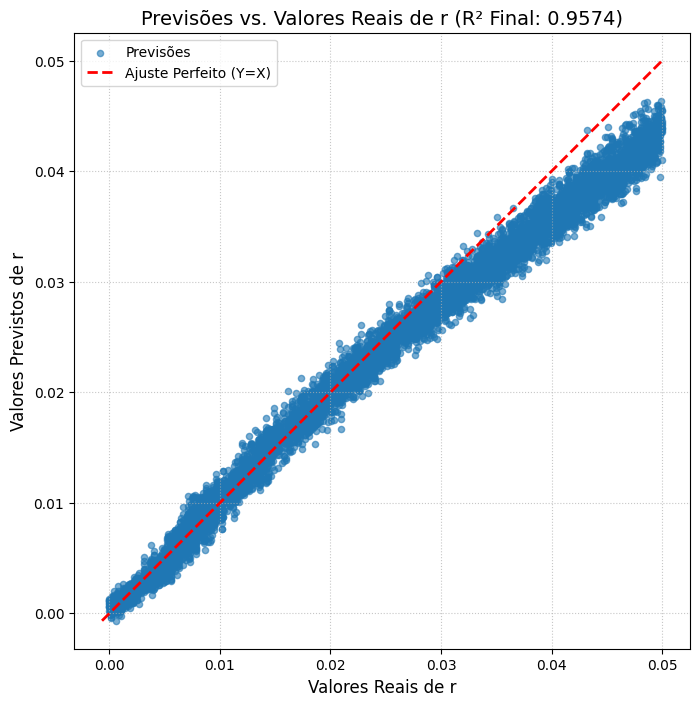

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Suponha que você já tem:
# y_true_original: valores verdadeiros de 'r' (na escala original)
# y_pred_original: valores previstos de 'r' (na escala original)

# Crie a linha de identidade X=Y
min_val = min(y_train.min(), y_pred_original.min())
max_val = max(y_train.max(), y_pred_original.max())
ideal_line = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(8, 8))

# 1. Scatter Plot dos Resultados
plt.scatter(y_train, y_pred_original, alpha=0.6, s=20, label='Previsões')

# 2. Linha de Identidade (Ajuste Perfeito)
plt.plot(ideal_line, ideal_line, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito (Y=X)')

plt.title(f'Previsões vs. Valores Reais de r (R² Final: {final_r2:.4f})', fontsize=14)
plt.xlabel('Valores Reais de r', fontsize=12)
plt.ylabel('Valores Previstos de r', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box') # Garante que os eixos tenham a mesma escala
plt.show()

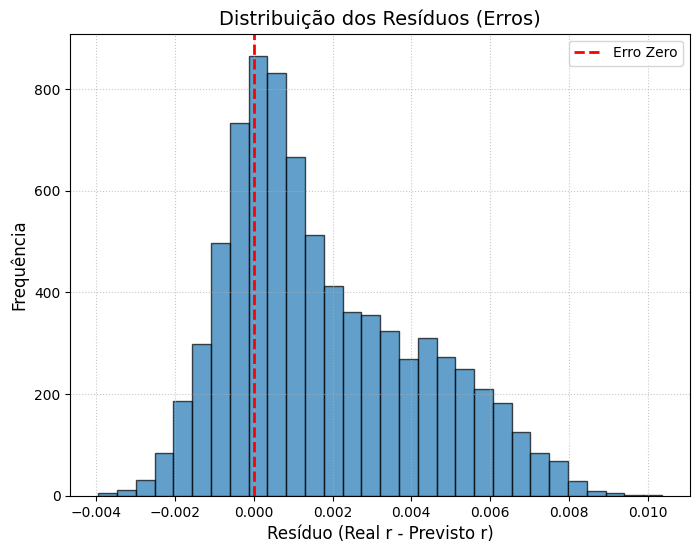

In [40]:
# Calcule os resíduos (True - Predicted)
residuals = y_true - y_pred_original

# Achata o array para 1D (o formato (N,))
residuals_1d = residuals.ravel()

plt.figure(figsize=(8, 6))

# Histograma dos resíduos
plt.hist(residuals_1d, bins=30, edgecolor='black', alpha=0.7)

# Linha vertical em zero (onde o centro do histograma deveria estar)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erro Zero')

plt.title('Distribuição dos Resíduos (Erros)', fontsize=14)
plt.xlabel('Resíduo (Real r - Previsto r)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

In [41]:
# --- PREPARAÇÃO ---
# Criando um DataFrame para facilitar a agregação
# Garantindo que y_train e y_pred_original são 1D para o DataFrame
y_true_flat = y_true.ravel()
y_pred_flat = y_pred_original.ravel()

df_results = pd.DataFrame({
    'y_true': y_true_flat,
    'y_pred': y_pred_flat
})

# AGREGAR: Agrupar por 'y_true' e calcular Média e Desvio Padrão para 'y_pred'
# 'y_true' (a variável agrupada) será o índice do novo DataFrame
df_grouped = df_results.groupby('y_true')['y_pred'].agg(['mean', 'std']).reset_index()

# Renomear as colunas para clareza
df_grouped.columns = ['y_true', 'y_pred_mean', 'y_pred_std']


# Cálculo do Resíduo Padronizado (em módulos, conforme solicitado)
# Evite a divisão por zero, substituindo desvios padrão zero por um valor pequeno (ex: 1e-6)
df_grouped['y_pred_std_safe'] = df_grouped['y_pred_std'].replace(0, 1e-6)
df_grouped['Standardized_Residual'] = (
    np.abs(df_grouped['y_true'] - df_grouped['y_pred_mean']) / df_grouped['y_pred_std_safe']
)

# Exibir o resultado da agregação (opcional)
print("Dados Agrupados (Exemplo):")
print(df_grouped.head())

Dados Agrupados (Exemplo):
     y_true  y_pred_mean  y_pred_std  y_pred_std_safe  Standardized_Residual
0  0.000000     0.000843    0.000347         0.000347               2.429485
1  0.000028     0.000534    0.000352         0.000352               1.436094
2  0.000103     0.000434    0.000303         0.000303               1.092584
3  0.000185     0.000074    0.000369         0.000369               0.302403
4  0.000229     0.000782    0.000379         0.000379               1.457888


## Visualização com barra de erros

Os dados utilizados associam 10 valores diferentes das features a um mesmo valor do target. O objetivo é simular os ruídos presentes em observações astronômicas.

Uma forma mais útil de visualizar os dados é portanto colapsar os 10 dados referentes à cada valor do target em seu valor médio e desvio padrão.

Além disso, plota-se gráfico de resíduos padronizados, que ajuda  visualizar o número de observações que se distanciam do valor real em mais de um desvio-padrão.



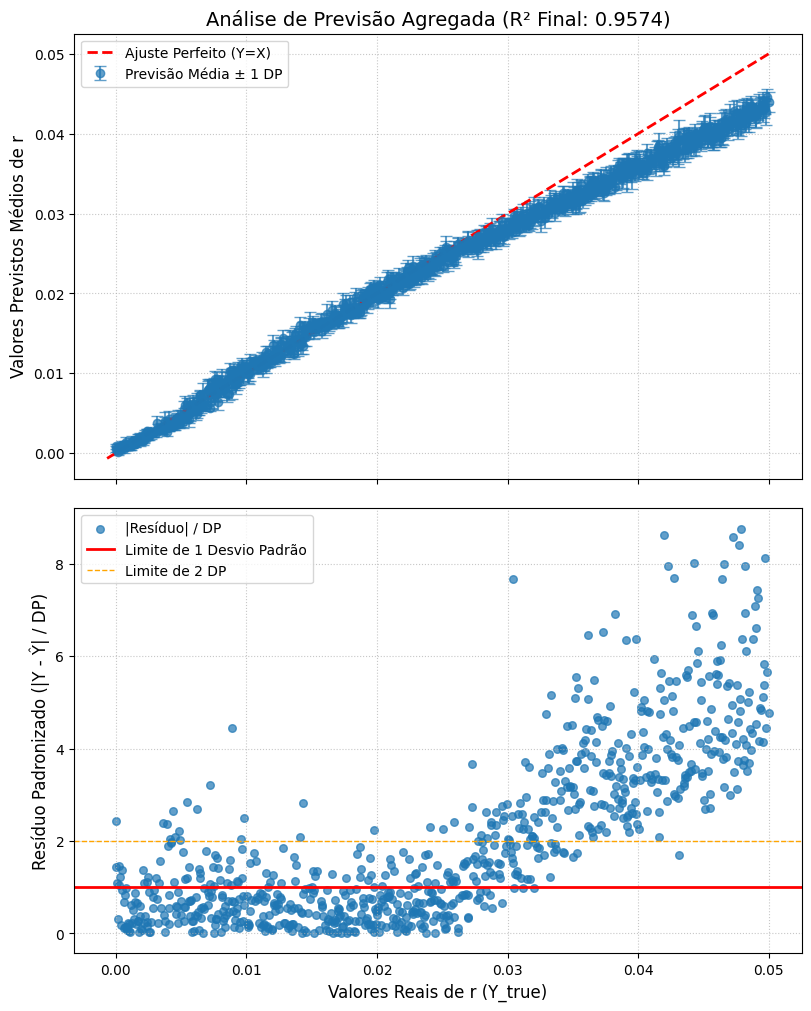

In [42]:
# Cria um espaço de figuras com 2 linhas e 1 coluna, compartilhando o eixo X
fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(8, 10), 
    sharex=True, # Os dois gráficos compartilham o mesmo eixo X
    gridspec_kw={'hspace': 0.05}, # Reduz o espaço entre os subplots
    constrained_layout=True 
)

# ==========================================================
# GRÁFICO SUPERIOR: Previsão Média vs. Real (Com Barras de Erro)
# ==========================================================

# 1. Plotar os pontos agregados com Barras de Erro
ax1.errorbar(
    x=df_grouped['y_true'],             
    y=df_grouped['y_pred_mean'],            
    yerr=df_grouped['y_pred_std'],          
    fmt='o',                                
    capsize=4,                              
    alpha=0.7,
    label='Previsão Média ± 1 DP'
)

# 2. Linha de Identidade (Ajuste Perfeito Y=X)
ax1.plot(ideal_line, ideal_line, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito (Y=X)')

ax1.set_title(f'Análise de Previsão Agregada (R² Final: {final_r2:.4f})', fontsize=14)
ax1.set_ylabel('Valores Previstos Médios de r', fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend()

# ==========================================================
# GRÁFICO INFERIOR: Resíduos Padronizados
# ==========================================================

# 1. Scatter Plot dos Resíduos Padronizados
ax2.scatter(
    df_grouped['y_true'], 
    df_grouped['Standardized_Residual'], 
    alpha=0.7, 
    s=30, 
    label='|Resíduo| / DP'
)

# 2. Linha de Referência Crítica (Z-Score = 1.0)
ax2.axhline(
    y=1.0, 
    color='red', 
    linestyle='-', 
    linewidth=2, 
    label='Limite de 1 Desvio Padrão'
)
ax2.axhline(y=2.0, color='orange', linestyle='--', linewidth=1, label='Limite de 2 DP')


ax2.set_xlabel('Valores Reais de r (Y_true)', fontsize=12)
ax2.set_ylabel('Resíduo Padronizado (|Y - Ŷ| / DP)', fontsize=12)
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend()

plt.show()